<a href="https://colab.research.google.com/github/cerasole/ml4hep/blob/main/GNNs/torch_OrganicMoleculesFormationEnergy_QM9dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks

Graphs are data structures composed of
- nodes (or vertices)
- edges (or archs, connections)

A graph is used to model pairwise relations (edges) between objects (nodes).

Examples of graphs can be
- accounts in a social network (with friendship connections),
- molecular shapes (the connections being the atomic/molecular bounds),
- images with cameras with pixels non on a square grid (connections being the network of nearby pixels)
- road networks (the connections being the roads among intersections).

So, graphs can also be quite irregular data.

GNNs are neural networks optimized for working with graphs.

===============================================================

The preliminary code on graphs is instead in https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

The code about the preprocessing, model and training/testing is at
https://github.com/pyg-team/pytorch_geometric/blob/master/examples/qm9_nn_conv.py

===============================================================

### Preliminaries: install pytorch-geometric (PyG), other useful packages and import all stuff (made for Colab)

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.4.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 29.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

In [3]:
import pathlib

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential
import networkx as nx

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set, GCNConv
from torch_geometric.utils import remove_self_loops, to_networkx

import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm.auto import trange

## Raw QM9 dataset download

In [7]:
dataset_path = pathlib.Path('data', 'QM9')
dataset_path

PosixPath('data/QM9')

In [ ]:
raw_dataset = QM9(dataset_path)

In [ ]:
raw_dataset, raw_dataset[0]

(QM9(130831),
 Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5]))

In [ ]:
type(raw_dataset)

torch_geometric.datasets.qm9.QM9

## First exploration of graphs in PyG

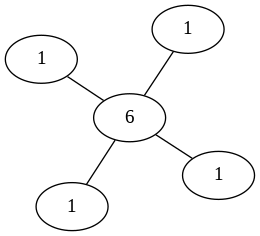

In [ ]:
def draw_graph(graph: torch_geometric.data.data.Data) -> Image:
    """
    Plots a molecule from QM9 dataset. Node labels are atomic numbers.
    Edge lengths and node positions are arbitrary.
    """
    graph_nx = to_networkx(graph,
                           to_undirected=True)
    graph_graphviz = nx.nx_agraph.to_agraph(graph_nx)
    for node, type_ in zip(graph_graphviz.iternodes(), graph.z.detach().numpy()):
        node.attr['label'] = str(type_)
    return Image(graph_graphviz.draw(format='png', prog="neato"))

draw_graph(raw_dataset[0])  ### The number in the graph is the atomic number!!!

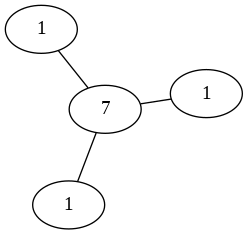

In [ ]:
draw_graph(raw_dataset[1]) ### The number in the graph is the atomic number!!!

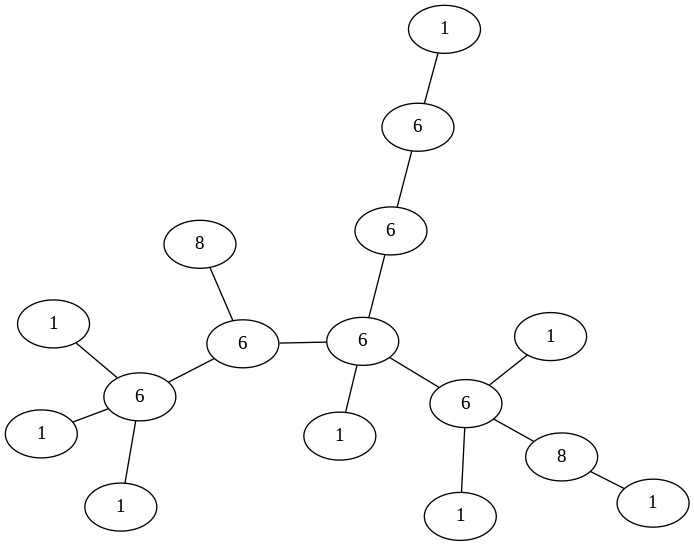

In [ ]:
draw_graph(raw_dataset[10000])

In [ ]:
raw_dataset.y  # the features!

tensor([[  0.0000,  13.2100, -10.5499,  ..., 157.7118, 157.7100, 157.7070],
        [  1.6256,   9.4600,  -6.9933,  ..., 293.6097, 293.5411, 191.3940],
        [  1.8511,   6.3100,  -7.9675,  ..., 799.5881, 437.9039, 282.9455],
        ...,
        [  1.2480,  73.6000,  -6.0763,  ...,   3.6712,   2.1431,   1.8950],
        [  1.9576,  77.4000,  -5.7743,  ...,   3.5285,   2.1513,   1.8658],
        [  0.8626,  69.4800,  -6.3022,  ...,   3.6402,   2.2176,   1.9379]])

In [ ]:
raw_dataset.y[:,7]  # formation energy

tensor([ -1101.4878,  -1538.1477,  -2079.0779,  ..., -10360.8418,
         -9924.5469, -10901.7803])

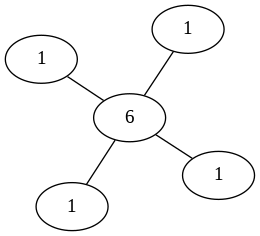

In [ ]:
draw_graph(raw_dataset[0])  ### The number in the graph is the atomic number!!!

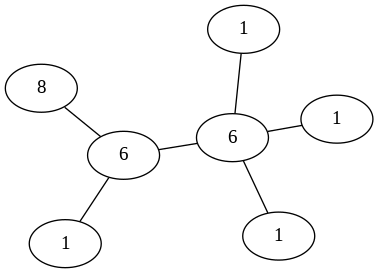

In [ ]:
draw_graph(raw_dataset[10])

In [ ]:
raw_dataset[10].edge_index   ### THIS ATTRIBUTE STATES THE CONNECTIVITY OF THE GRAPH

# Nodes are ordered per decreasing number of connections:
# - the node "6" on the right has 4 connections and it is labeled as 0
# - the node "6" on the left has 3 connections and it is labeled as 1
# - the three "1" nodes on the right connected to node 0 are labeled as 3, 4, 5
# - the remaining 2 are labeled as 2 and 6.

# In this graph, there are 7 nodes and 6*2=12 connections (they are counted in both directions).

tensor([[0, 0, 0, 0, 1, 1, 1, 2, 3, 4, 5, 6],
        [1, 3, 4, 5, 0, 2, 6, 1, 0, 0, 0, 1]])

In [ ]:
#
raw_dataset[10].x  ### The nodes of this graph are 7 and have 11 features in total

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [ ]:
#
raw_dataset[10].edge_attr  ### The edges (connections) of this graph are 12 and have 4 features

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [ ]:
raw_dataset[10].y    ### Targets we want our GNN models become able to predict.

In [ ]:
raw_dataset[0].y  # targets to train against

tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])

In [ ]:
raw_dataset[10].pos

tensor([[-0.0029,  1.5099,  0.0087],
        [ 0.0261,  0.0033, -0.0375],
        [ 0.9423, -0.6551, -0.4568],
        [ 0.9228,  1.9263, -0.3915],
        [-0.8620,  1.8785, -0.5648],
        [-0.1505,  1.8439,  1.0429],
        [-0.8944, -0.4864,  0.3577]])

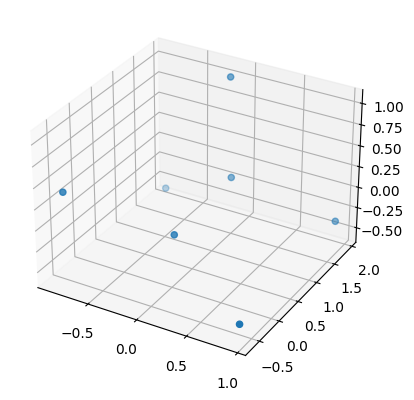

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*raw_dataset[10].pos.T);

In [ ]:
raw_dataset[0].z  # --> Atomic number of the atoms : this is CH4

tensor([6, 1, 1, 1, 1])

In [ ]:
raw_dataset[10].z  # --> Atomic number of the atoms : this is CH4

tensor([6, 6, 8, 1, 1, 1, 1])

## Processed-QM9 dataset download

Transformation of the input data.
 - SelectTarget selects only the desider target column.
 - Distance appends Euclidean distance between pos vectors to the edge attributes.

In [4]:
TARGET_Y = 7

class SelectTarget(object):
    def __init__(self, target_column: int):
        self.target_column = target_column

    def __call__(self, data: torch.Tensor) -> torch.Tensor:
        data.y = data.y[:, self.target_column]
        return data


In [5]:
import torch_geometric.transforms as T
transform = T.Compose([SelectTarget(TARGET_Y), T.Distance(norm=False)])

In [ ]:
st = SelectTarget(TARGET_Y)

In [ ]:
raw_dataset.y

tensor([ -1101.4878,  -1538.1477,  -2079.0779,  ..., -10360.8418,
         -9924.5469, -10901.7803])

In [ ]:
st(raw_dataset)

IndexError: too many indices for tensor of dimension 1

In [ ]:
T.Distance(norm=False)(raw_dataset)

QM9(130831)

Before, we have downloaded the raw dataset, now we download a processed one

In [8]:
dataset_path = pathlib.Path('data', 'QM9')
dataset_path

torch.manual_seed(42)
dataset = QM9(dataset_path, transform=transform).shuffle()

Extracting data/QM9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


In [ ]:
dataset[0].x  # same as before

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.,

In [ ]:
dataset[0].edge_attr  # DIFFERENT THAN BEFORE! NOW, WE HAVE ADDED THE EUCLIDEAN DISTANCE!

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 1.5076],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0968],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0964],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0950],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.5076],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.5220],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.5075],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.5364],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.5220],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.5561],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0952],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0971],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.5561],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.5592],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.5084],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0911],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.5592],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.5171],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0947],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0964],


In [ ]:
dataset[0].y   ### DIFFERENT THAN BEFORE, NOW WE HAVE ONLY 1 TARGET INSTEAD OF 19!

tensor([1.5249])

In [9]:
mean = dataset.data.y.mean(dim = 0, keepdim = True)
std = dataset.data.y.std(dim = 0, keepdim = True)
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean[:, TARGET_Y].item(), std[:, TARGET_Y].item()

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [ ]:
len(dataset)

130831

In [11]:
test_dataset = dataset[:10000]
val_dataset = dataset[10000:20000]
#train_dataset = dataset[20000:40000]
train_dataset = dataset[20000:]

In [12]:
# Create pytorch objects for handling the data
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

Here we define "SlimeNet", a base GNN for molecules.

- A fully-connected linear layer from dataset.num_fratures to hidden_dim + ReLU

- A GCNConv layer from hidden_dim to hidden_dim + ReLU. A GCNConv should be similar to a convolutional layer with a kernel. It has weights and biases and computes the weighted sum of the nodes that are connected.

- A Set2Set layer from hidden_dim with processing_steps = 1.

- A linear layer from 2 * hidden_dim to hidden_dim + ReLU

- A linear layer from hidden_dim to 1 dimension --> the output, which is the formation energy.

The ReLU functions are needed to introduce non-linearity.

In [13]:
class SlimeNet (torch.nn.Module):
    def __init__ (self, hidden_dim: int):
        super().__init__()
        self.lin0 = torch.nn.Linear(dataset.num_features, hidden_dim)
        self.conv = GCNConv(hidden_dim, hidden_dim)
        self.set2set = Set2Set(hidden_dim, processing_steps = 1)
        self.lin1 = torch.nn.Linear(2*hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 1)
        return

    def forward (self, data):
        # Nothing special, just a sequece of transformations
        # But pay attention to the API signatures of the graph layers
        # Apply a linear layer+ReLu to the featues of each node independenly
        out = F.relu(self.lin0(data.x))
        # Apply a graph convolution
        out = F.relu(self.conv(out, data.edge_index))
        # Apply a Set2Set pooling operation from
        # "Order Matters: Sequence to sequence for sets"
        # https://arxiv.org/abs/1511.06391 paper
        out = self.set2set(out, data.batch)
        # And a classic fully-connected head
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out.view(-1)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
def evaluate_model (model, epochs = 15):
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode = "min",
                                                         factor = 0.7,
                                                         patience = 5,
                                                         min_lr = 1e-5)

  def train (epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      loss = F.mse_loss(model(data), data.y)
      loss.backward()
      loss_all += loss.item() * data.num_graphs
      optimizer.step()
    return loss_all / len(train_loader.dataset)

  def test (loader):
    model.eval()
    error = 0
    for data in loader:
      data = data.to(device)
      error += (model(data)*std - data.y*std).abs().sum().item() # MAE = Mean Absolute Value
    return error / len(loader.dataset)

  best_val_error = None
  for epoch in trange(epochs):
        lr = scheduler.optimizer.param_groups[0]['lr']
        loss = train(epoch)
        val_error = test(val_loader)
        scheduler.step(val_error)

        if best_val_error is None or val_error <= best_val_error:
            test_error = test(test_loader)
            best_val_error = val_error

        print(f'Epoch: {epoch:03d}, LR: {lr:7f}, Loss: {loss:.7f}, '
              f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')


In [ ]:
evaluate_model(SlimeNet(16))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.9360331, Val MAE: 682.2457555, Test MAE: 692.3671388
Epoch: 001, LR: 0.001000, Loss: 0.5933710, Val MAE: 532.5896913, Test MAE: 543.4872798
Epoch: 002, LR: 0.001000, Loss: 0.4681427, Val MAE: 453.7991430, Test MAE: 463.2675317
Epoch: 003, LR: 0.001000, Loss: 0.4253800, Val MAE: 456.0827143, Test MAE: 463.2675317
Epoch: 004, LR: 0.001000, Loss: 0.4050134, Val MAE: 389.3668957, Test MAE: 399.0253112
Epoch: 005, LR: 0.001000, Loss: 0.3909459, Val MAE: 427.9929280, Test MAE: 399.0253112
Epoch: 006, LR: 0.001000, Loss: 0.3846820, Val MAE: 444.2028717, Test MAE: 399.0253112
Epoch: 007, LR: 0.001000, Loss: 0.3812430, Val MAE: 475.1593389, Test MAE: 399.0253112
Epoch: 008, LR: 0.001000, Loss: 0.3811800, Val MAE: 458.9295218, Test MAE: 399.0253112
Epoch: 009, LR: 0.001000, Loss: 0.3779068, Val MAE: 434.4780684, Test MAE: 399.0253112
Epoch: 010, LR: 0.001000, Loss: 0.3769869, Val MAE: 508.2433061, Test MAE: 399.0253112
Epoch: 011, LR: 0.000700, Loss: 0.3742532, 

In [ ]:
evaluate_model(SlimeNet(32))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.8836458, Val MAE: 668.8567674, Test MAE: 677.7750961
Epoch: 001, LR: 0.001000, Loss: 0.5294055, Val MAE: 475.4350585, Test MAE: 486.9262510
Epoch: 002, LR: 0.001000, Loss: 0.4270985, Val MAE: 456.2156684, Test MAE: 467.1971671
Epoch: 003, LR: 0.001000, Loss: 0.3952709, Val MAE: 385.4468011, Test MAE: 396.9561031
Epoch: 004, LR: 0.001000, Loss: 0.3841560, Val MAE: 394.7426786, Test MAE: 396.9561031
Epoch: 005, LR: 0.001000, Loss: 0.3777942, Val MAE: 419.6859521, Test MAE: 396.9561031
Epoch: 006, LR: 0.001000, Loss: 0.3744634, Val MAE: 514.0045986, Test MAE: 396.9561031
Epoch: 007, LR: 0.001000, Loss: 0.3775749, Val MAE: 358.8073724, Test MAE: 370.2840534
Epoch: 008, LR: 0.001000, Loss: 0.3739850, Val MAE: 407.7393865, Test MAE: 370.2840534
Epoch: 009, LR: 0.001000, Loss: 0.3700027, Val MAE: 495.6620143, Test MAE: 370.2840534
Epoch: 010, LR: 0.001000, Loss: 0.3727975, Val MAE: 357.4901332, Test MAE: 368.3193978
Epoch: 011, LR: 0.001000, Loss: 0.3697926, 

In [16]:
evaluate_model(SlimeNet(16))    # now I trained over the whole training dataset, but it did not improve the situation

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.5492907, Val MAE: 458.3443070, Test MAE: 467.9994939
Epoch: 001, LR: 0.001000, Loss: 0.3804831, Val MAE: 413.5321781, Test MAE: 424.1209260
Epoch: 002, LR: 0.001000, Loss: 0.3735572, Val MAE: 470.7731718, Test MAE: 424.1209260
Epoch: 003, LR: 0.001000, Loss: 0.3716354, Val MAE: 360.0547035, Test MAE: 371.8423251
Epoch: 004, LR: 0.001000, Loss: 0.3700227, Val MAE: 472.3903448, Test MAE: 371.8423251
Epoch: 005, LR: 0.001000, Loss: 0.3697451, Val MAE: 408.0780770, Test MAE: 371.8423251
Epoch: 006, LR: 0.001000, Loss: 0.3689559, Val MAE: 370.1749675, Test MAE: 371.8423251
Epoch: 007, LR: 0.001000, Loss: 0.3681621, Val MAE: 436.2009010, Test MAE: 371.8423251
Epoch: 008, LR: 0.001000, Loss: 0.3675304, Val MAE: 402.5895682, Test MAE: 371.8423251
Epoch: 009, LR: 0.001000, Loss: 0.3664409, Val MAE: 400.2735556, Test MAE: 371.8423251
Epoch: 010, LR: 0.000700, Loss: 0.3652922, Val MAE: 457.6825167, Test MAE: 371.8423251
Epoch: 011, LR: 0.000700, Loss: 0.3646596, 

Task 1. Now is the time for upgrading the model! Build and test a network like SlimeNet, but with 2 and 3 applications of the same convolutional layer. [1 point]

In [20]:
class ConvNetSame (torch.nn.Module):
    def __init__ (self, hidden_dim: int, n_convs: int):
        super().__init__()
        self.n_convs = n_convs
        self.lin0 = torch.nn.Linear(dataset.num_features, hidden_dim)
        self.conv = GCNConv(hidden_dim, hidden_dim)
        self.set2set = Set2Set(hidden_dim, processing_steps = 1)
        self.lin1 = torch.nn.Linear(2*hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 1)
        return

    def forward (self, data):
        # Nothing special, just a sequece of transformations
        # But pay attention to the API signatures of the graph layers
        # Apply a linear layer+ReLu to the featues of each node independenly
        out = F.relu(self.lin0(data.x))
        # Apply n_convs graph convolutions
        for i in range(self.n_convs):
            out = F.relu(self.conv(out, data.edge_index))

        # Apply a Set2Set pooling operation from
        # "Order Matters: Sequence to sequence for sets"
        # https://arxiv.org/abs/1511.06391 paper
        out = self.set2set(out, data.batch)
        # And a classic fully-connected head
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out.view(-1)

In [21]:
evaluate_model(ConvNetSame(16, 2))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.5318682, Val MAE: 419.7026970, Test MAE: 428.6525383
Epoch: 001, LR: 0.001000, Loss: 0.3843563, Val MAE: 387.1060414, Test MAE: 397.4703542
Epoch: 002, LR: 0.001000, Loss: 0.3769033, Val MAE: 382.5678538, Test MAE: 392.5980915
Epoch: 003, LR: 0.001000, Loss: 0.3728536, Val MAE: 388.2534412, Test MAE: 392.5980915
Epoch: 004, LR: 0.001000, Loss: 0.3708254, Val MAE: 377.3207956, Test MAE: 387.2037024
Epoch: 005, LR: 0.001000, Loss: 0.3695754, Val MAE: 432.8953869, Test MAE: 387.2037024
Epoch: 006, LR: 0.001000, Loss: 0.3695784, Val MAE: 433.4043450, Test MAE: 387.2037024
Epoch: 007, LR: 0.001000, Loss: 0.3695388, Val MAE: 349.7201000, Test MAE: 360.1762046
Epoch: 008, LR: 0.001000, Loss: 0.3687683, Val MAE: 376.5624400, Test MAE: 360.1762046
Epoch: 009, LR: 0.001000, Loss: 0.3672843, Val MAE: 465.2222582, Test MAE: 360.1762046
Epoch: 010, LR: 0.001000, Loss: 0.3675180, Val MAE: 513.2412947, Test MAE: 360.1762046
Epoch: 011, LR: 0.001000, Loss: 0.3665754, 

In [22]:
class Conv2Net(torch.nn.Module):
    def __init__(self, hidden_dim: int):
        """
        Args:
            hidden_dim: the number of units used in the hidden layers
        """
        super().__init__()
        self.lin0 = torch.nn.Linear(dataset.num_features, hidden_dim)

        # Define two layers. Remember, to have two layers with
        # different
        ### YOUR CODE HERE
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

        self.set2set = Set2Set(hidden_dim, processing_steps=1)
        self.lin1 = torch.nn.Linear(2 * hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, data: torch_geometric.data.Data) -> torch_geometric.data.Data:
        out = F.relu(self.lin0(data.x))

        # Apply the GCNN layers. Don't forget ReLu
        ### YOUR CODE HERE
        out = F.relu(self.conv1(out, data.edge_index))
        out = F.relu(self.conv2(out, data.edge_index))

        out = self.set2set(out, data.batch)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out.view(-1)

In [23]:
evaluate_model(Conv2Net(16))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.5303071, Val MAE: 408.4991687, Test MAE: 419.2015938
Epoch: 001, LR: 0.001000, Loss: 0.3806113, Val MAE: 577.7569228, Test MAE: 419.2015938
Epoch: 002, LR: 0.001000, Loss: 0.3741392, Val MAE: 427.0288890, Test MAE: 419.2015938
Epoch: 003, LR: 0.001000, Loss: 0.3731201, Val MAE: 384.8419610, Test MAE: 394.4946549
Epoch: 004, LR: 0.001000, Loss: 0.3715707, Val MAE: 351.5361040, Test MAE: 362.0350834
Epoch: 005, LR: 0.001000, Loss: 0.3701581, Val MAE: 402.5200680, Test MAE: 362.0350834
Epoch: 006, LR: 0.001000, Loss: 0.3697839, Val MAE: 460.8788662, Test MAE: 362.0350834
Epoch: 007, LR: 0.001000, Loss: 0.3684894, Val MAE: 448.5200636, Test MAE: 362.0350834
Epoch: 008, LR: 0.001000, Loss: 0.3680146, Val MAE: 515.5593354, Test MAE: 362.0350834
Epoch: 009, LR: 0.001000, Loss: 0.3675835, Val MAE: 386.7120936, Test MAE: 362.0350834
Epoch: 010, LR: 0.001000, Loss: 0.3672710, Val MAE: 392.9649771, Test MAE: 362.0350834
Epoch: 011, LR: 0.000700, Loss: 0.3650226, 